In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P

In [3]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [4]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

In [5]:
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 1000
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)
    
    Ys = []
    
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter) % 50 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Error", C)
#         Stop lying about P-values
        if iter == 100:
            P = P / 4.
#         Ys.append(np.copy(Y))
    # Return solution
    return Y, Ys

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Running example on 2,500 Fashion MNIST images...
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 1.991512
Error 24.91368180053725
Error 15.841752788687304
Error 15.48438410859807
Error 1.5657104127299983
Error 1.3250736133314966
Error 1.2214077065565334
Error 1.1655277050513546
Error 1.1310276328914068
Error 1.107734260927442
Error 1.0910010558943373
Error 1.0784975801551677
Error 1.068912516586564
Error 1.0612809668581817
Error 1.055088719224481
Error 1.0499867939101788
Error 1.0457347155884515
Error 1.0421496737407838
Error 1.0390816803843468
Error 1.036442602099267
Error 1.0341376412088787


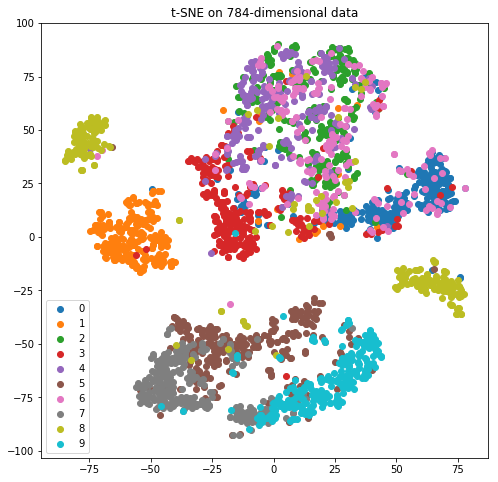

<Figure size 432x288 with 0 Axes>

In [11]:
# %matplotlib notebook

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
print("Running example on 2,500 Fashion MNIST images...")

ns = [784]
# ns = np.arange(10, 20)+1

# X = np.loadtxt("mnist2500_X.txt")
# labels = np.loadtxt("mnist2500_labels.txt")

directory = "./"

train_data = pd.read_csv(directory+'train.csv')

train_x = train_data.drop(['id', 'label'], axis = 1).values
train_y = train_data['label'].values

permute = np.random.permutation(train_x.shape[0])

X = train_x[permute[:2500]].astype(float)/255
labels = train_y[permute[:2500]]

# def animate_2(Y, labels):
#     """
#     This function gets called by FuncAnimation
#     each time called it will replot with a diff Y value

#     Y: t-SNE at each iter

#     return: 
#         ax: ploted value
#     """
#     scatterss = []
#     ax1.clear()
#     for g in np.unique(labels):
#         i = np.where(labels == g)
#         scatterss.append(ax1.scatter(Y[i,0], Y[i,1], label=int(g)))
#     plt.legend()
#     return scatterss

# def init_():
#     plt.title("t-SNE on "+str(10)+"-dimensional data")
#     plt.legend()
#     return [scat]

for n in ns:
    Y , Ys = tsne(X, 2, n, 20.0)
    fig, ax = plt.subplots(figsize=(8,8))
    for g in np.unique(labels):
        i = np.where(labels == g)
        ax.scatter(Y[i,0], Y[i,1], label=int(g))
    plt.title("t-SNE on "+str(n)+"-dimensional data")
    plt.legend()
    plt.savefig("tsne_"+str(n)+".png")
    plt.show()
    plt.clf()
    
#     fig_1, ax1 = plt.subplots()
#     scat = ax1.scatter(np.arange(10), np.arange(10)*2)

#     # print(Ys[0][0])
#     Ys = np.array(Ys)
#     ani = FuncAnimation(fig_1, animate_2, frames=Ys[np.arange(0,1000,10)], interval=10, blit=True, init_func=init_, fargs=(labels,))
#     Writer = animation.writers['pillow']
#     writer = Writer(fps=10, metadata=dict(artist='PRASAD'), bitrate=1800)
#     ani.save('gif_animated_'+str(n)+'.gif', writer=writer)
#     plt.show()